# Predicting Insurance Cross Sell Opportunities

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Importing the dataset

In [3]:
insurance_df = pd.read_csv('data/insurance_cross_sell.csv')
insurance_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
insurance_df.describe().round(2)


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00
mean,190555.00,38.82,1.00,26.39,0.46,30564.39,112.03,154.35,0.12
std,110016.84,15.51,0.05,13.23,0.50,17213.16,54.20,83.67,0.33
min,1.00,20.00,0.00,0.00,0.00,2630.00,1.00,10.00,0.00
25%,95278.00,25.00,1.00,15.00,0.00,24405.00,29.00,82.00,0.00
50%,190555.00,36.00,1.00,28.00,0.00,31669.00,133.00,154.00,0.00
75%,285832.00,49.00,1.00,35.00,1.00,39400.00,152.00,227.00,0.00
max,381109.00,85.00,1.00,52.00,1.00,540165.00,163.00,299.00,1.00


In [5]:
insurance_df.count()

id                      381109
Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

From dataset importing, we can observe that the dataset does not have any missing values. The dataset has 12 features and 381109 observations. The dataset has 8 categorical features and 4 numerical features which are  "ID", "Age", "Annual_Premium", "Vintage". 
The target variable is 'Response' which is a binary variable. 

In [6]:
insurance_df_categorical = insurance_df.drop(["id","Annual_Premium", "Age", "Vintage"],  axis=1).copy()
for column in insurance_df_categorical.columns:
    print(insurance_df_categorical[column].value_counts())

Gender
Male      206089
Female    175020
Name: count, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64
Previously_Insured
0    206481
1  

Moreover the dataset is imbalanced as the number of observations for 'Response' = 1 is 46710 and for 'Response' = 0 is 334399, and other categorical features are also imbalanced (for example, 'Vehicle_Age' has 164786 observations for '< 1 Year' and 200316 observations for '> 2 Years'). This is an important factor to consider while building the model.<br>
It is interesting to observe that the dataset has 2 features 'Policy_Sales_Channel' and 'Region_Code' which have 155 and 53 unique values respectively. This is a large number of unique values for categorical features and would be another challenging point while building the model.<br>
There are 812 buyers who have not a driving license, and just 41 of them are interested in the vehicle insurance. This is a very small number of observations.

In [7]:
responce_with_no_licence = insurance_df[insurance_df["Driving_License"] == 0]["Response"]
print(responce_with_no_licence.value_counts())

#potrebbe trattarsi di una bicicletta o di un monopattino elettrico ad esempio


Response
0    771
1     41
Name: count, dtype: int64


# Data Preprocessing

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, classification_report

def encode_set(dataset, X=np.array([]), label_encoder=LabelEncoder(), one_hot_encoder=None):
    for column in dataset.columns:
        X_tmp = label_encoder.fit_transform(dataset[column])
        X_tmp = X_tmp.reshape(X_tmp.shape[0],1)
        if(one_hot_encoder is not None):
            X_tmp = one_hot_encoder.fit_transform(X_tmp[:,0].reshape(-1,1)).toarray()
        if X.shape[0] == 0:
            X = X_tmp
        else:
            X = np.hstack((X_tmp, X))
        print(f"Categorical feature: {column}, Number of categories: {X_tmp[1,:].shape[0]}")
    return X


def evaluate_model(model, data, scaler=None, train_test_dataset='Train', print_report=False, threshold=0.5):
    '''
    Evaluate model performance on a given dataset. To be used after training the model.
    :param model: trained model
    :param data: tuple of features and labels
    :param scaler: scaler used to scale the features
    :param train_test_dataset: string to identify the dataset
    :param print_report: boolean to print classification report 
    '''
    X_, y_ = data
    if scaler is not None:
        X_ = scaler.transform(X_)

    y_pred_ = model.predict(X_)
    y_pred_proba_ = model.predict_proba(X_)

    if threshold != 0.5:
        y_pred_ = np.where(y_pred_proba_[:,1] > threshold, 1, 0)


    print('Accuracy: {:.3f}'.format(model.score(X_, y_)))
    print(f"Log-Loss: {log_loss(y_, y_pred_proba_):.3f}")
    if print_report:
        print(f"{train_test_dataset} Report:")
        print(classification_report(y_, y_pred_))


def random_split_train_test_set(X, Y, test_size=0.20, random_state=42):
    m = X.shape[0]
    m_train = int(m * (1-test_size))
    m_test = m - m_train

    
    random_indices = np.random.permutation(m)
    X_rand = X[random_indices]
    Y_rand = Y[random_indices]

    X_training, X_test, Y_training, Y_test = train_test_split(X_rand, Y_rand, test_size =float(m_test)/float(m), random_state=random_state)
    return X_training, X_test, Y_training, Y_test

def plot_confusion_matrix(confusion_matrix, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(data=confusion_matrix, annot=True, fmt='g')
    plt.title(title)
    ax.xaxis.set_ticklabels(['Predicted No', 'Predicted Yes'])
    ax.yaxis.set_ticklabels(['No', 'Yes'])
    plt.show()

In [9]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

X = insurance_df.drop(["id","Response","Gender", "Driving_License", "Region_Code", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage", "Policy_Sales_Channel"], axis=1).copy()
print(X.shape)
insurance_df_categorical = insurance_df_categorical.drop("Response", axis=1).copy()
X = encode_set(insurance_df_categorical, X, label_encoder, one_hot_encoder)


(381109, 3)
Categorical feature: Gender, Number of categories: 2
Categorical feature: Driving_License, Number of categories: 2
Categorical feature: Region_Code, Number of categories: 53
Categorical feature: Previously_Insured, Number of categories: 2
Categorical feature: Vehicle_Age, Number of categories: 3
Categorical feature: Vehicle_Damage, Number of categories: 2
Categorical feature: Policy_Sales_Channel, Number of categories: 155


In [10]:
Y = insurance_df["Response"].copy()
Y = label_encoder.fit_transform(Y)
Y

array([1, 0, 1, ..., 0, 0, 0])

In [11]:
RANDOM_SEED = 42

X_training, X_test, Y_training, Y_test = random_split_train_test_set(X, Y, test_size=0.20, random_state = RANDOM_SEED) 

m_training = X_training.shape[0]
m_test = X_test.shape[0]

#let's see what the fraction of ones in the entire dataset is
print("Fraction of ones in the train set: ", round(float(sum(Y_training))/float(m_training), 3))
print("Fraction of ones in the test set: ", round(float(sum(Y_test))/float(m_test), 3))
print("Fraction of ones in the entire dataset: ", round(float(sum(Y_training)+sum(Y_test))/float(m_training+m_test), 3))


Fraction of ones in the train set:  0.122
Fraction of ones in the test set:  0.124
Fraction of ones in the entire dataset:  0.123


In [12]:
std_scaler = StandardScaler()
X_training = std_scaler.fit_transform(X_training)

## Model 1: LogisticRegression with L1

In [13]:
from sklearn.linear_model import LogisticRegression
#log_reg = LogisticRegression(penalty='l1', C=10000, solver='saga', class_weight='balanced')
log_reg = LogisticRegression(penalty='l2', C=0.01, class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True)


Accuracy: 0.693
Log-Loss: 0.473
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    267603
           1       0.28      0.94      0.43     37284

    accuracy                           0.69    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.69      0.75    304887



In [14]:
evaluate_model(log_reg, (X_test, Y_test), scaler=std_scaler, train_test_dataset='Test', print_report=True)

Accuracy: 0.693
Log-Loss: 0.473
Test Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     66796
           1       0.28      0.94      0.43      9426

    accuracy                           0.69     76222
   macro avg       0.63      0.80      0.61     76222
weighted avg       0.90      0.69      0.75     76222



In [15]:
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, RocCurveDisplay, classification_report
y_pred_proba_training = log_reg.predict_proba(X_training)
y_pred_train = log_reg.predict(X_training)
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = log_reg.predict(X_test)

confusion_matrix_train = confusion_matrix(Y_training, y_pred_train)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

print("Confusion matrix for training set:")
print(confusion_matrix_train)
print("Confusion matrix for test set:")
print(confusion_matrix_test)



Confusion matrix for training set:
[[176138  91465]
 [  2274  35010]]
Confusion matrix for test set:
[[ 4971 61825]
 [  735  8691]]


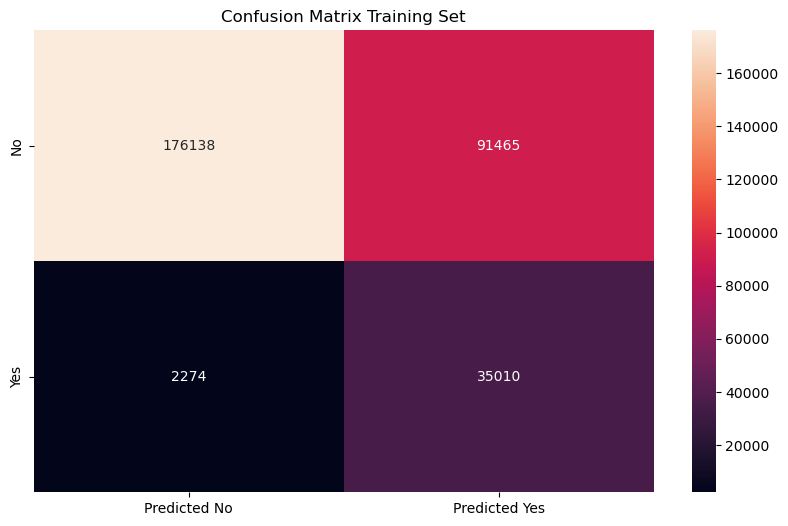

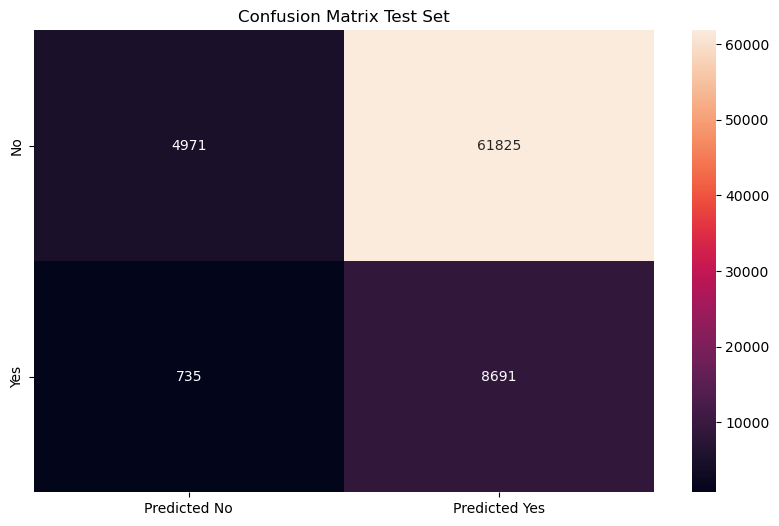

In [16]:
plot_confusion_matrix(confusion_matrix_train, "Confusion Matrix Training Set")
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")


## Model 2: LogisticRegression with Cross Validation and polynomial features

In [17]:
from sklearn.linear_model import LogisticRegressionCV


In [18]:
def logistic_regression_CV(X_training, Y_training, cv=10, penalty='l2', solver="lbfgs" ,class_weight='balanced'):
    log_reg_cv = LogisticRegressionCV(Cs=10, cv=cv, penalty=penalty, class_weight=class_weight, solver=solver)
    log_reg_cv.fit(X_training, Y_training)

    print("Values of parameter C tried in {}-fold Cross-Validation: {}".format(cv, log_reg_cv.Cs_ ))
    CV_accuracies = np.divide(np.sum(log_reg_cv.scores_[1],0),10)
    print("Accuracies obtained for the different values of C with {}-fold Cross-Validation: {}".format(cv, CV_accuracies ))

    print("Best value C according to {}-fold Cross-Validation: {}".format(cv, log_reg_cv.C_[0] ))

    regL2_best_CV_accuracy = np.max(log_reg_cv.scores_[1])
    print("{}-fold Cross-Validation accuracies obtained with the best value of parameter C: {}".format(cv, regL2_best_CV_accuracy))

    regL2_full = LogisticRegression(C = log_reg_cv.C_[0], penalty=penalty, class_weight=class_weight, solver=solver)


    #fit the model using the best C on the entire training set
    regL2_full.fit(X_training, Y_training)


    evaluate_model(regL2_full, (X_training, Y_training), print_report=True)
    return regL2_full


Values of parameter C tried in 10-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 10-fold Cross-Validation: [0.69016718 0.69106915 0.69193832 0.6920564  0.69209904 0.69209904
 0.69209576 0.69209576 0.69209576 0.69209576]
Best value C according to 10-fold Cross-Validation: 2.782559402207126
10-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.6949619522435057
Accuracy: 0.693
Log-Loss: 0.473
Train Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79    267603
           1       0.28      0.94      0.43     37284

    accuracy                           0.69    304887
   macro avg       0.63      0.80      0.61    304887
weighted avg       0.90      0.69      0.75    304887

Accuracy: 0.693
Log-Loss: 0.474
Test Report:
       

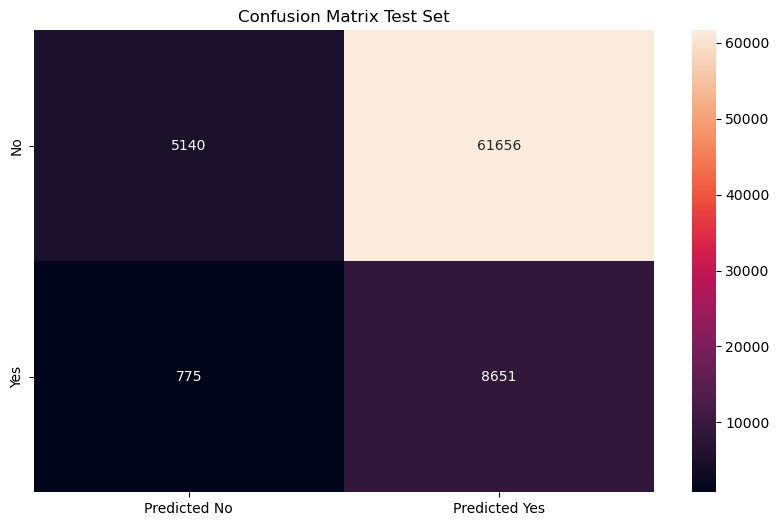

In [19]:
regL2_full = logistic_regression_CV(X_training, Y_training)

evaluate_model(regL2_full, (X_test, Y_test), scaler=std_scaler, train_test_dataset='Test', print_report=True)

y_pred_proba_test = regL2_full.predict_proba(X_test)
y_pred_test = regL2_full.predict(X_test)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

## Rimuovo samples per ribalanciare il dataset


In [20]:
df = pd.read_csv('data/insurance_cross_sell.csv')

df = df.drop(['id'], axis=1)

for column in df.columns:
    print(df[column].value_counts())





Gender
Male      206089
Female    175020
Name: count, dtype: int64
Age
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: count, Length: 66, dtype: int64
Driving_License
1    380297
0       812
Name: count, dtype: int64
Region_Code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0  

<Axes: >

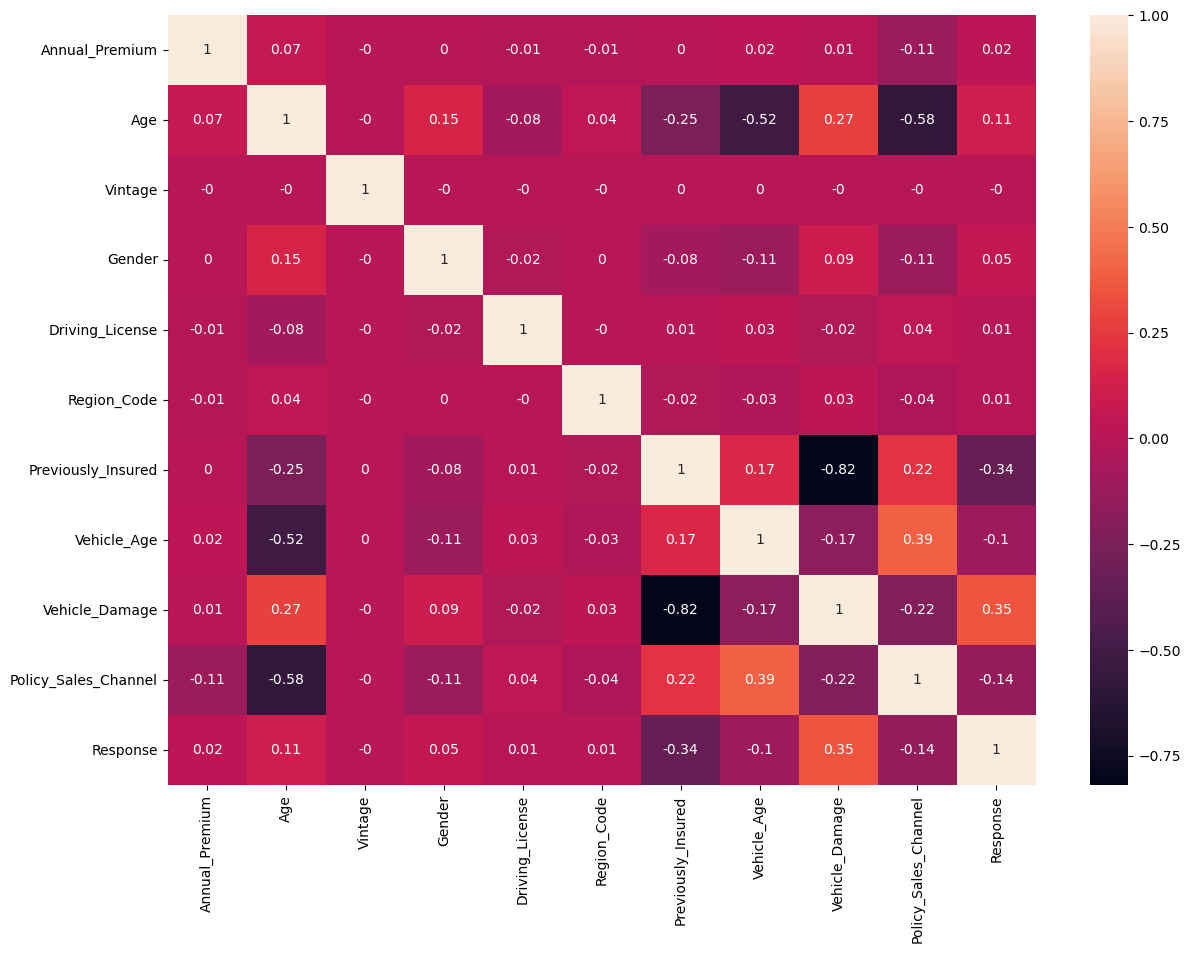

In [21]:
df_categorical = df.drop(["Annual_Premium", "Age", "Vintage", "Response"],  axis=1).copy()

for column in df_categorical.columns:
    df_categorical[column] = label_encoder.fit_transform(df_categorical[column])

df_numerical = df[["Annual_Premium", "Age", "Vintage"]].copy()

df_to_handle = pd.concat([df_numerical, df_categorical], axis=1)
df_to_handle = pd.DataFrame(std_scaler.fit_transform(df_to_handle), columns=df_to_handle.columns)
df_to_handle = pd.concat([df_to_handle, df["Response"]], axis=1)


plt.figure(figsize=(14, 10))
corr_matrix = df_to_handle.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

In [22]:
#Remove highly correlated features
#df_to_handle = df.drop(["Vehicle_Age", "Vehicle_Damage"], axis=1)
df_to_handle = df.drop(["Vehicle_Damage"], axis=1)


In [23]:
#Remove features with low correlation with the target
#df_to_handle = df_to_handle.drop(["Region_Code", "Annual_Premium"], axis=1)
df_to_handle = df_to_handle.drop(["Region_Code", "Vintage", "Driving_License"], axis=1)


In [24]:
#Remove outliers
df_to_handle = df_to_handle[df_to_handle["Age"] < 70]
df_to_handle = df_to_handle.groupby('Policy_Sales_Channel').filter(lambda x: len(x)> 10000)
df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [25]:
#Balance the dataset
df_to_handle = df_to_handle.groupby('Response').apply(lambda x: x.sample(df_to_handle.Response.value_counts().min(), random_state=RANDOM_SEED)).reset_index(drop=True)

In [26]:
df_to_handle.head()

,Gender,Age,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Response
0,Female,24,1,< 1 Year,28439.0,152.0,0
1,Female,24,0,< 1 Year,28174.0,152.0,0
2,Female,52,0,1-2 Year,68800.0,26.0,0
3,Male,23,1,< 1 Year,30422.0,152.0,0
4,Male,35,0,1-2 Year,23086.0,152.0,0


In [27]:
for column in df_to_handle.columns:
    print(df_to_handle[column].value_counts())

Gender
Male      40436
Female    30724
Name: count, dtype: int64
Age
24    3949
23    3718
22    3264
25    3242
21    2382
45    2119
44    2107
46    2064
43    2062
26    2026
42    1925
47    1894
41    1877
48    1842
40    1747
27    1642
49    1598
50    1529
39    1512
28    1498
38    1390
51    1374
52    1303
29    1259
37    1258
36    1226
30    1218
31    1206
53    1190
35    1189
33    1176
34    1175
54    1136
32    1131
55     995
20     896
56     859
57     832
58     790
59     716
60     644
61     625
62     534
63     527
64     491
65     487
67     411
66     403
69     371
68     351
Name: count, dtype: int64
Previously_Insured
0    51281
1    19879
Name: count, dtype: int64
Vehicle_Age
1-2 Year     40859
< 1 Year     25929
> 2 Years     4372
Name: count, dtype: int64
Annual_Premium
2630.0     11457
69856.0       39
45179.0       14
31470.0       11
43707.0       10
           ...  
17525.0        1
76417.0        1
20113.0        1
36310.0        1
45516.0 

In [28]:
#df_categorical = df_to_handle.drop(["Age", "Vintage", "Response"],  axis=1).copy()
df_categorical = df_to_handle.drop(["Age", "Annual_Premium", "Response"],  axis=1).copy()

for column in df_categorical.columns:
    df_categorical[column] = label_encoder.fit_transform(df_categorical[column])


Gender
 0.871675    40436
-1.147216    30724
Name: count, dtype: int64
Previously_Insured
-0.622614    51281
 1.606131    19879
Name: count, dtype: int64
Vehicle_Age
-0.798117    40859
 0.839873    25929
 2.477863     4372
Name: count, dtype: int64
Policy_Sales_Channel
-1.118374    22632
 0.736287    21016
-0.191044    20969
 1.663617     3353
 2.590947     3190
Name: count, dtype: int64


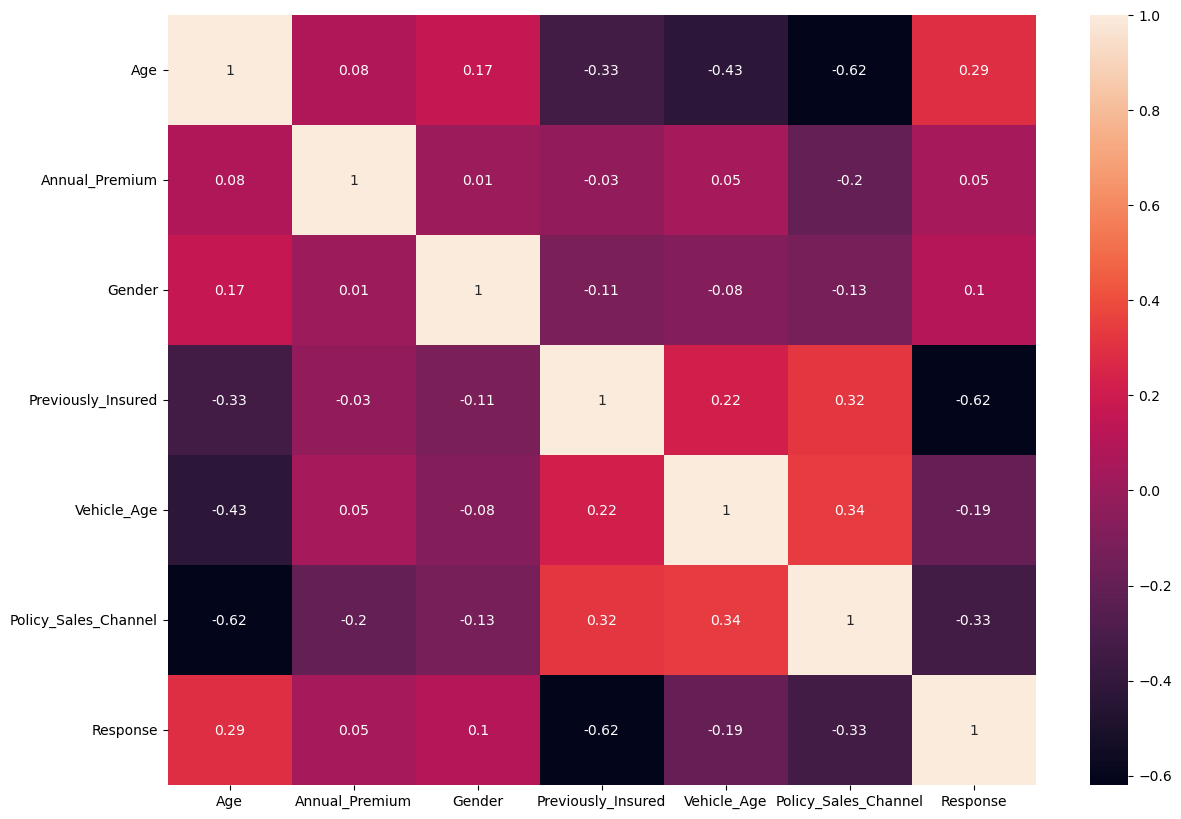

In [29]:
#df_numerical = df_to_handle[["Age", "Vintage"]].copy()
df_numerical = df_to_handle[["Age", "Annual_Premium"]].copy()


response = df_to_handle["Response"].copy()

df_to_handle = pd.concat([df_numerical, df_categorical], axis=1)
df_to_handle = pd.DataFrame(std_scaler.fit_transform(df_to_handle), columns=df_to_handle.columns)
df_to_handle = pd.concat([df_to_handle, response], axis=1)

plt.figure(figsize=(14, 10))
corr_matrix = df_to_handle.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)

for column in df_categorical.columns:
    print(df_to_handle[column].value_counts())

In [30]:
df_to_train = df_to_handle[["Age", "Previously_Insured", "Vehicle_Age", "Policy_Sales_Channel" ,"Response"]]

ids = np.array([i for i in range(df_to_train.shape[0])])

print(ids)
df_to_train.reindex(ids)


X = df_to_train.drop("Response", axis=1).copy()
Y = df_to_train["Response"].copy()

X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED)

m_training = X_training.shape[0]
m_test = X_test.shape[0]




[    0     1     2 ... 71157 71158 71159]


In [31]:
print(X_training)

       Previously_Insured  Vehicle_Age  Policy_Sales_Channel
49995           -0.622614    -0.798117             -1.118374
38111           -0.622614    -0.798117             -0.191044
47157           -0.622614     0.839873             -1.118374
27098            1.606131    -0.798117             -0.191044
2531            -0.622614     0.839873              0.736287
...                   ...          ...                   ...
37194           -0.622614     0.839873             -1.118374
6265             1.606131     0.839873              2.590947
54886           -0.622614     2.477863             -1.118374
860              1.606131     0.839873              0.736287
15795           -0.622614     0.839873              0.736287

[49812 rows x 3 columns]


In [32]:
log_reg = LogisticRegression(penalty='l1', C=0.001, solver="liblinear", class_weight='balanced')

log_reg.fit(X_training, Y_training)
evaluate_model(log_reg, (X_training, Y_training), print_report=True, threshold=0.6)

Accuracy: 0.786
Log-Loss: 0.452
Train Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.73     24915
           1       0.70      0.92      0.80     24897

    accuracy                           0.77     49812
   macro avg       0.79      0.77      0.76     49812
weighted avg       0.79      0.77      0.76     49812



In [33]:
evaluate_model(log_reg, (X_test, Y_test), train_test_dataset='Test', print_report=True, threshold=0.6)

Accuracy: 0.787
Log-Loss: 0.452
Test Report:
              precision    recall  f1-score   support

           0       0.89      0.61      0.73     10665
           1       0.71      0.92      0.80     10683

    accuracy                           0.77     21348
   macro avg       0.80      0.77      0.76     21348
weighted avg       0.80      0.77      0.76     21348



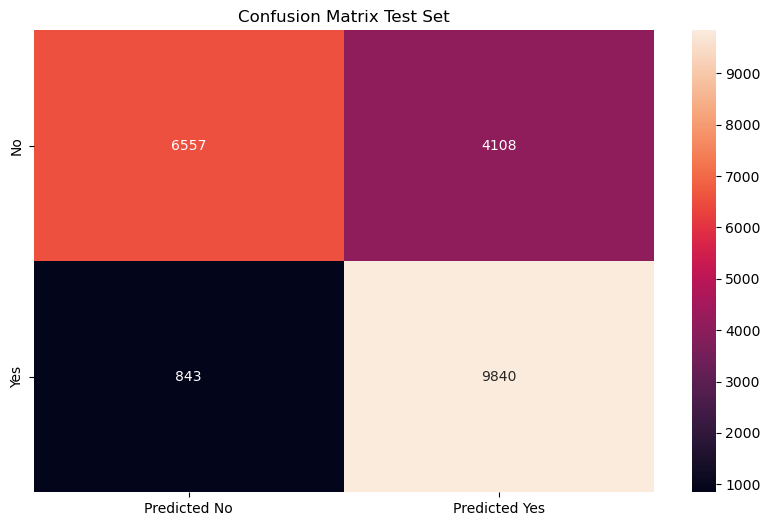

In [34]:
y_pred_proba_test = log_reg.predict_proba(X_test)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.6, 1, 0)

confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)

plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

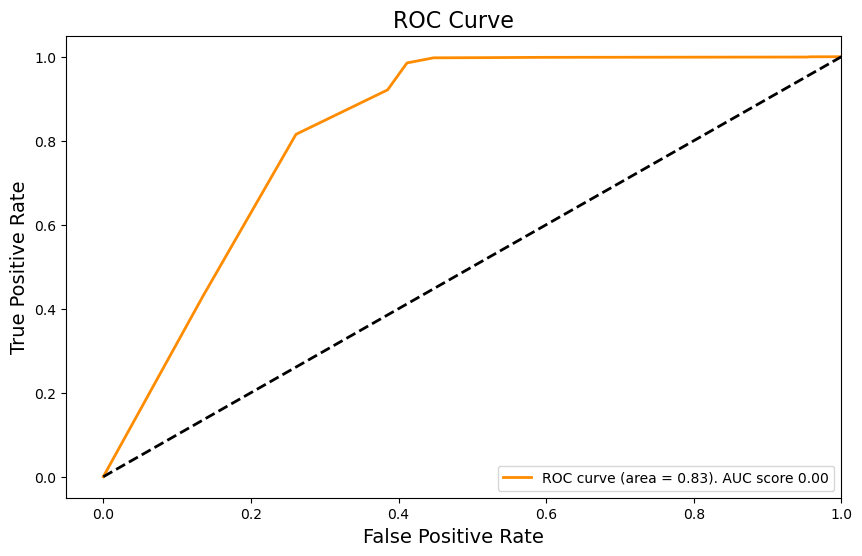

In [35]:
#plot roc curve
def plot_roc_curve(Y_test, y_pred_proba_test, multiclass=None,average=None):

    fpr, tpr, _ = roc_curve(Y_test, y_pred_proba_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_score = 0
    if multiclass is not None and average is not None:
        auc_score = roc_auc_score(Y_test, y_pred_proba_test[:,1], multi_class=multiclass, average=average)
    plt.figure(figsize=(10, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f). AUC score %0.2f' % (roc_auc, auc_score))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(Y_test, y_pred_proba_test)

Values of parameter C tried in 5-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 5-fold Cross-Validation: [0.38820969 0.39280696 0.391482   0.391482   0.391482   0.391482
 0.391482   0.391482   0.391482   0.391482  ]
Best value C according to 5-fold Cross-Validation: 0.000774263682681127
5-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.7922103995181691
Accuracy: 0.786
Log-Loss: 0.448
Train Report:
              precision    recall  f1-score   support

           0       0.97      0.59      0.73     24915
           1       0.70      0.98      0.82     24897

    accuracy                           0.79     49812
   macro avg       0.84      0.79      0.78     49812
weighted avg       0.84      0.79      0.78     49812

Accuracy: 0.786
Log-Loss: 0.448
Train Report:
         

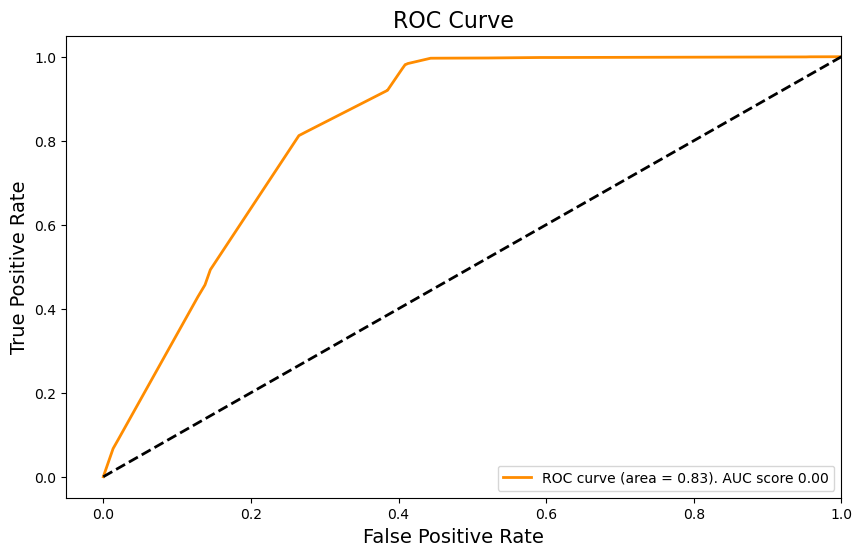

Values of parameter C tried in 5-fold Cross-Validation: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
Accuracies obtained for the different values of C with 5-fold Cross-Validation: [0.38820969 0.39303784 0.391482   0.391482   0.39142177 0.39142177
 0.39142177 0.39142177 0.39142177 0.39142177]
Best value C according to 5-fold Cross-Validation: 0.000774263682681127
5-fold Cross-Validation accuracies obtained with the best value of parameter C: 0.7931138325637422
Accuracy: 0.783
Log-Loss: 0.444
Train Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     24915
           1       0.71      0.97      0.82     24897

    accuracy                           0.78     49812
   macro avg       0.83      0.78      0.78     49812
weighted avg       0.83      0.78      0.78     49812

Accuracy: 0.783
Log-Loss: 0.444
Train Report:
       

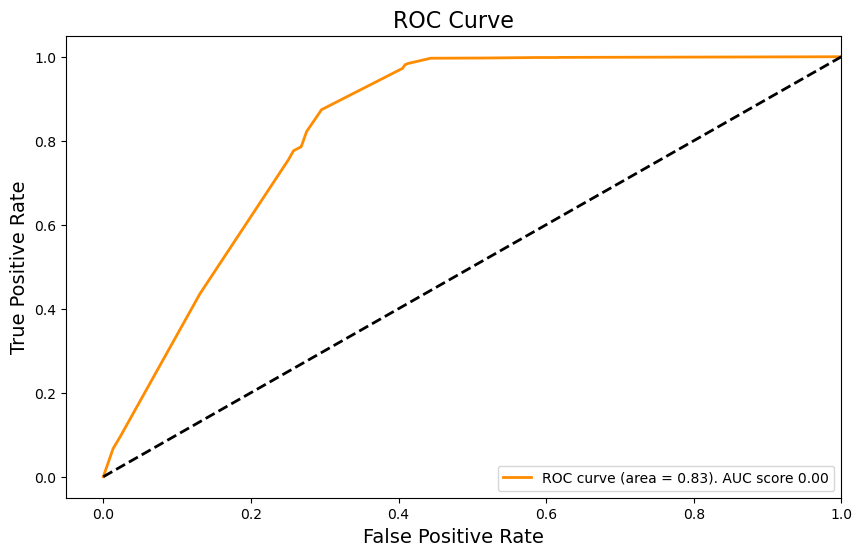

KeyboardInterrupt: 

In [36]:
from sklearn.preprocessing import PolynomialFeatures
for i in range (2, 5):
    poly = PolynomialFeatures(i)
    X_training_poly = poly.fit_transform(X_training)
    regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')
    evaluate_model(regL2_full, (X_training_poly, Y_training), train_test_dataset='Train', print_report=True, threshold=0.6)
    y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
    plot_roc_curve(Y_training, y_pred_proba_training)
#poly = PolynomialFeatures(2)
#X_training_poly = poly.fit_transform(X_training)
#regL2_full = logistic_regression_CV(X_training_poly, Y_training, cv=5, penalty='l1', solver="liblinear", class_weight='balanced')

In [ ]:
X_test_poly = poly.fit_transform(X_test)
evaluate_model(regL2_full, (X_test_poly, Y_test), train_test_dataset='Test', print_report=True, threshold=0.6)


Accuracy: 0.791
Log-Loss: 0.424
Test Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78     10665
           1       0.76      0.85      0.80     10683

    accuracy                           0.79     21348
   macro avg       0.79      0.79      0.79     21348
weighted avg       0.79      0.79      0.79     21348



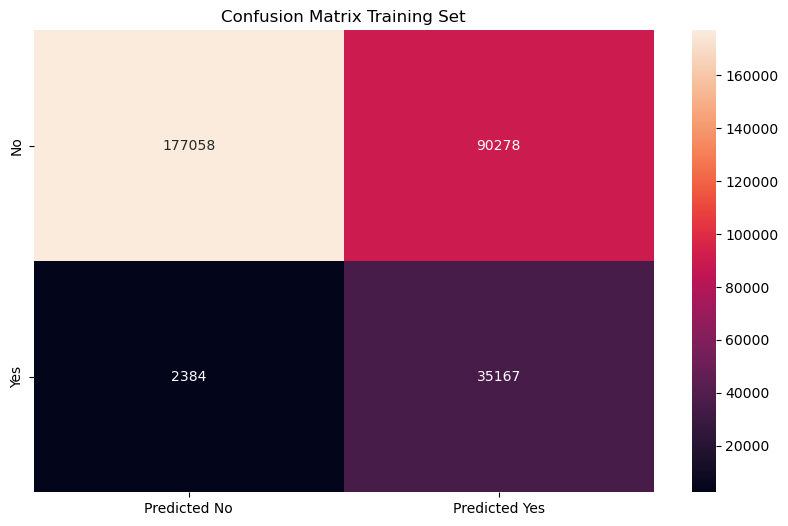

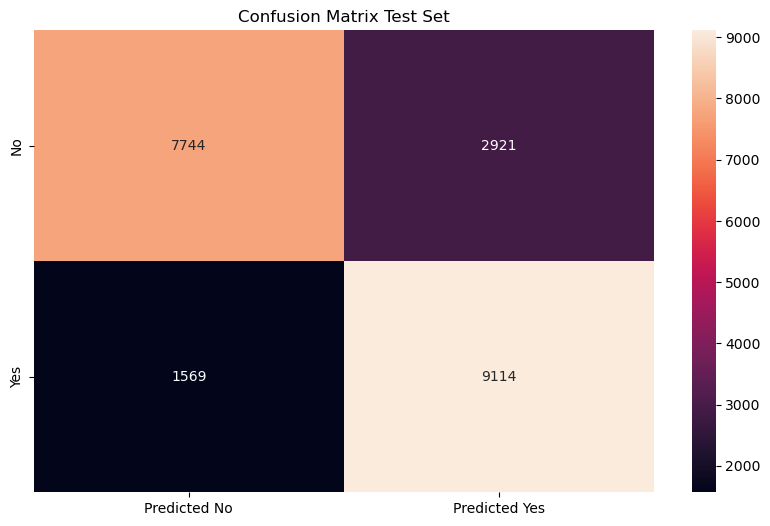

In [ ]:
y_pred_proba_training = regL2_full.predict_proba(X_training_poly)
y_pred_training = np.where(y_pred_proba_training[:,1] > 0.6, 1, 0)
confusion_matrix_training = confusion_matrix(Y_training, y_pred_training)

y_pred_proba_test = regL2_full.predict_proba(X_test_poly)
y_pred_test = np.where(y_pred_proba_test[:,1] > 0.6, 1, 0)
confusion_matrix_test = confusion_matrix(Y_test, y_pred_test)


plot_confusion_matrix(confusion_matrix_train, "Confusion Matrix Training Set")
plot_confusion_matrix(confusion_matrix_test, "Confusion Matrix Test Set")

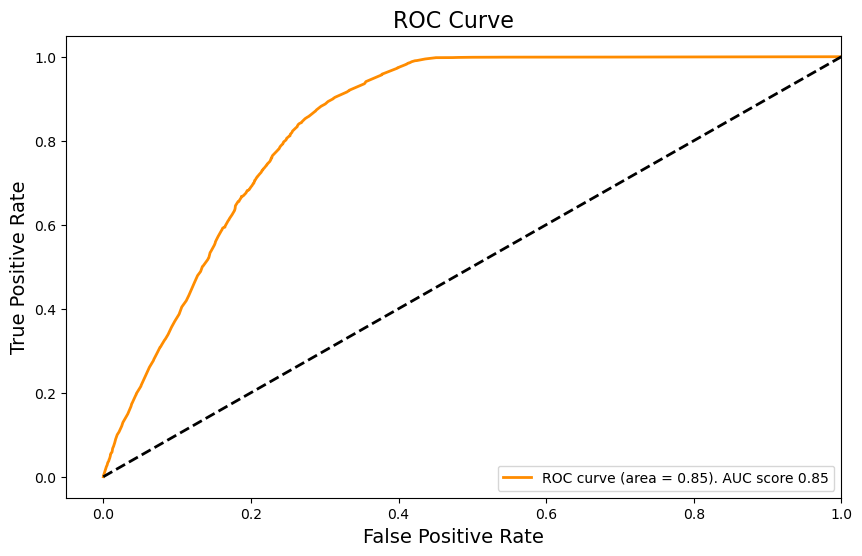

In [ ]:
plot_roc_curve(Y_test, y_pred_proba_test, multiclass='ovo', average='macro')
